<h2> Objective of this notebook </h2>
<p> To explore a dataset about stellar objects and build models to classify them with given astronomical measurements and understand the interpretability of some models.</p>

<h2> Source of dataset </h2>
<p> From Kaggle: <a href=https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17>Stellar Classification dataset </a></p>
<p> Features are astronomical measures and target is galaxy, quasar object (QSO), and star</p>

<h2> Exploratory Data Analysis </h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

<p> <strong>Basic information</strong> of the dataset</p>

In [2]:
df = pd.read_csv('star.csv')
print('Dataset shape:',df.shape)
print('Datatypes:', df.dtypes.unique())
print('With null values:',df.isnull().values.any())

Dataset shape: (100000, 18)
Datatypes: [dtype('float64') dtype('int64') dtype('O')]
With null values: False


In [3]:
df.head(3)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299


<p> Measurements and class are retained. Others are IDs, measurement date, and angles (alpha and delta) which are not relevant. </p>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [5]:
df2 = df.select_dtypes(['float','object']).drop(['obj_ID', 'spec_obj_ID','alpha','delta'], axis=1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   u         100000 non-null  float64
 1   g         100000 non-null  float64
 2   r         100000 non-null  float64
 3   i         100000 non-null  float64
 4   z         100000 non-null  float64
 5   class     100000 non-null  object 
 6   redshift  100000 non-null  float64
dtypes: float64(6), object(1)
memory usage: 5.3+ MB


In [6]:
df2['class'].value_counts()

GALAXY    59445
STAR      21594
QSO       18961
Name: class, dtype: int64

In [7]:
df2.describe()

,u,g,r,i,z,redshift
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,21.980468,20.531387,19.645762,19.084854,18.668810,0.576661
std,31.769291,31.750292,1.854760,1.757895,31.728152,0.730707
min,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,-0.009971
25%,20.352353,18.965230,18.135828,17.732285,17.460677,0.054517
50%,22.179135,21.099835,20.125290,19.405145,19.004595,0.424173
75%,23.687440,22.123767,21.044785,20.396495,19.921120,0.704154
max,32.781390,31.602240,29.571860,32.141470,29.383740,7.011245


<p>A <strong>boxplot</strong> suggests outlier(s) at u, g, and z.</p>

<AxesSubplot:>

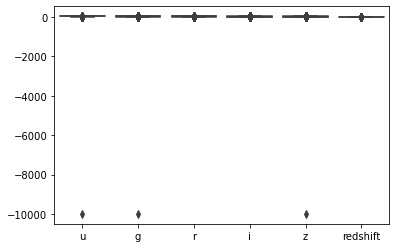

In [8]:
sns.boxplot(data=df2.select_dtypes('float64'))

In [9]:
#generate 3 separately series sorted in ascending order  
temp = {}
for key in ['u','g','z']:
    temp[key] = df2[key].sort_values().values

In [10]:
#the index does not correspond to the original dataframe
temp = pd.DataFrame(temp).head(5) 
temp

,u,g,z
0,-9999.00000,-9999.00000,-9999.000000
1,10.99623,10.49820,9.612333
2,12.10168,10.51139,10.225510
3,12.26240,10.67180,10.441310
4,12.30349,10.73097,10.650560


In [11]:
df2[df2['u']==df2['u'].min()]

,u,g,r,i,z,class,redshift
79543,-9999.0,-9999.0,18.1656,18.01675,-9999.0,STAR,0.000089


<p> It happens to be one outlier with very low u, g, and z (row 79543) which should be dropped. After removing this data point, the distributions still have data points outside the 1.5 interquartile range. </p>

In [12]:
df3 = df2.drop(79543).reset_index(drop=True)

<AxesSubplot:>

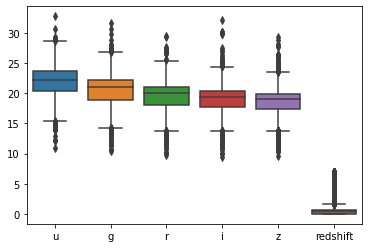

In [13]:
sns.boxplot(data=df3)

<p> Below is a summary of the characteristics of the dataset which inform further feature engineering:</p>
<ul>
    <li> There are <strong>3 Target Classes:</strong>GALAXY, STAR, and QSO</li>
    <li> All features are continuous but in slightly different scales</li>
    <li> <strong>Redshift, u, g, r, i, z</strong> have <strong>outliers</strong> outside the IQR</li> 
</p>

<h2> Feature Selection and Engineering </h2>

<p>First drop data points <strong>outside 1.5 IQR</strong>.</p>

In [14]:
#obtaining the 1.5IQR for a column
def iqr(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3-q1
    return q1-1.5*iqr, q3+1.5*iqr

In [15]:
df4 = df3.copy()

(90632, 7)


<AxesSubplot:>

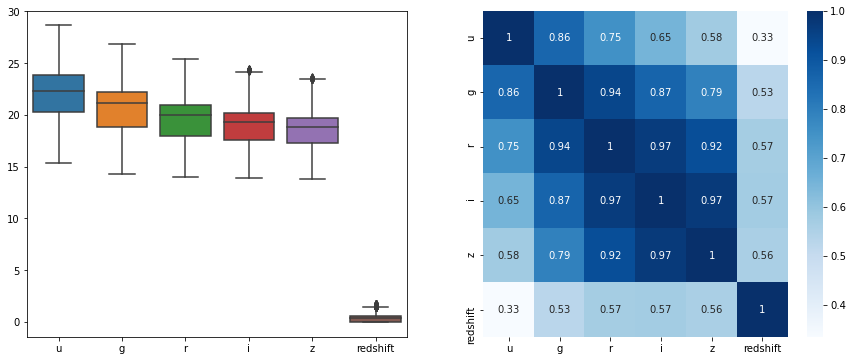

In [16]:
#remove data points outside 1.5 IQR for each column iteratively
for col in df4.drop('class', axis=1).columns:
    lq, uq = iqr(df[col])
    df4 = df4[(df4[col] >= lq) & (df4[col] <= uq)]
print(df4.shape)

fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.boxplot(data=df4, ax=ax[0])
sns.heatmap(df4.drop('class', axis=1).corr(), annot=True, ax=ax[1], cmap='Blues')

<p> The features are quite positively correlated</p> 

<h2> Model Training </h2>

<p> Three models are selected to fit the data to serve different purposes.</p>
<ol><strong>
    <li>Logistic Regression - interpretability</li>
    <li>Random Forest - ensemble method</li>
    <li>Gradient Boosting - boosting</li>
</ol></strong>

<p> They will be evaluated by accuracy metrics. </p>

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression as LGR
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as GBC, AdaBoostClassifier as ABC

<p> First perform <strong>Min-max scaling</strong> followed by <strong>train_test_split</strong>. This is to ensure all features share the same scale for fitting the coefficients. </p>

In [18]:
x, y = df4.drop('class', axis=1), df4['class']

In [19]:
mm = MinMaxScaler()
for col in x.columns:
    x[col] = mm.fit_transform(x[[col]])
    
x.sample(3)

,u,g,r,i,z,redshift
73148,0.538544,0.594871,0.670937,0.703686,0.795114,0.962185
7369,0.607628,0.652245,0.572886,0.550141,0.558957,0.349717
45984,0.828224,0.612452,0.463324,0.401191,0.381220,0.441211


<p> The dataset is imbalanced</p>

In [20]:
y.value_counts(normalize=True)

GALAXY    0.652441
STAR      0.237378
QSO       0.110182
Name: class, dtype: float64

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

<p> <strong>Random Under Sampling and SMOTE</strong> are used to further transform the samples </p>

In [22]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [23]:
smote = SMOTE()
under = RandomUnderSampler()

x_smo, y_smo = smote.fit_resample(x_train, y_train)
x_under, y_under = under.fit_resample(x_train, y_train)

<p> Define model builders to run GridSearchCV with different hpyerparameters.  Then compute the best_estimator with score with original (without resampling), SMO, and UnderSampling datasets.</p>

<h4>1. Logistic Regression </h4>

In [24]:
def build_lgr(x_train, y_train, class_weight=['balanced'], scoring='f1_macro'): 
    lgr = LGR(solver='saga', multi_class='multinomial', random_state=42) #only saga supports multinomial + L1/L2 penalty

    params_lgr = {'penalty':['none','l1','l2'],
                  'class_weight':class_weight,
                  'C':[0.001, 0.01, 0.1, 1, 10]}

    grid = GridSearchCV(lgr, params_lgr, cv=StratifiedKFold(n_splits=4), scoring=scoring)
    grid.fit(x_train, y_train)
    
    print('Best score:', grid.best_score_)
    print(grid.best_estimator_)
   
    return grid

<p>For skewed dataset, there is an additional option for equal class weights </p> 

In [25]:
lgr = build_lgr(x_train, y_train, class_weight=['balanced', {'GALAXY':1, 'QSO':1, 'STAR':1}])

Best score: 0.9255603849033768
LogisticRegression(C=0.001, class_weight={'GALAXY': 1, 'QSO': 1, 'STAR': 1},
                   multi_class='multinomial', penalty='none', random_state=42,
                   solver='saga')


In [26]:
lgr_smo = build_lgr(x_smo, y_smo)

Best score: 0.9345492436601068
LogisticRegression(C=0.001, class_weight='balanced', multi_class='multinomial',
                   penalty='none', random_state=42, solver='saga')


In [27]:
lgr_under = build_lgr(x_under, y_under)

Best score: 0.9317292886312821
LogisticRegression(C=0.001, class_weight='balanced', multi_class='multinomial',
                   penalty='none', random_state=42, solver='saga')


<h4> 2. Random Forest </h4>

In [28]:
def build_rf(x_train, y_train, class_weight=['balanced','balanced_subsample'], scoring='f1_macro'):
    rf = RF(oob_score=True, random_state=42)

    params = {'n_estimators': [10*(n+1) for n in range(30)],
              'max_depth' : [2*n+1 for n in range(2) ], #only 6 features
              'max_features':["sqrt", "log2"],
              'class_weight':class_weight}

    grid = GridSearchCV(rf, params, cv=4, scoring=scoring, n_jobs=-1)
    grid.fit(x_train, y_train)
    print('Best score:', grid.best_score_)
    print(grid.best_estimator_)
   
    return grid

In [29]:
rf = build_rf(x_train, y_train, ['balanced','balanced_subsample',{'GALAXY':1, 'QSO':1, 'STAR':1}])

Best score: 0.9005525138868297
RandomForestClassifier(class_weight='balanced', max_depth=3, n_estimators=40,
                       oob_score=True, random_state=42)


In [30]:
rf_smo = build_rf(x_smo, y_smo)

Best score: 0.9307016994993953
RandomForestClassifier(class_weight='balanced_subsample', max_depth=3,
                       n_estimators=40, oob_score=True, random_state=42)


In [31]:
rf_under = build_rf(x_under, y_under)

Best score: 0.9303451552394556
RandomForestClassifier(class_weight='balanced', max_depth=3, n_estimators=40,
                       oob_score=True, random_state=42)


<h4> 3. Gradient Boosting </h4>

In [32]:
def build_gbc(x_train, y_train, class_weight=['balanced','balanced_subsample'], scoring='f1_macro'):
    gbc = GBC(random_state=42)

    params = {'n_estimators': [10, 20, 40, 100, 200, 400],
              'learning_rate': [0.001, 0.01, 0.1],
              'subsample': [1.0, 0.5],
              'max_features': [1, 2, 3, 4]}

    grid = GridSearchCV(gbc, params, cv=4, scoring=scoring, n_jobs=-1)
    grid.fit(x_train, y_train)
    
    print('Best score:', grid.best_score_)
    print(grid.best_estimator_)
   
    return grid

In [33]:
gbc = build_gbc(x_train, y_train)

Best score: 0.9544487863450312
GradientBoostingClassifier(max_features=2, n_estimators=400, random_state=42)


In [34]:
gbc_smo = build_gbc(x_smo, y_smo)

Best score: 0.9631460394360145
GradientBoostingClassifier(max_features=4, n_estimators=400, random_state=42)


In [35]:
gbc_under = build_gbc(x_under, y_under)

Best score: 0.9578549308757139
GradientBoostingClassifier(max_features=2, n_estimators=400, random_state=42)


<h3> Model Evaluation </h3>

<p> From the above models, it is observed that <strong>SMOTE resampling</strong> gives the best fit in all models and produces a <strong>training score over 0.93</strong>. </p>
<p> For logistic regression, the coefficients for individual class are further analysed.</p>

In [85]:
pd.DataFrame(data=lgr_smo.best_estimator_.coef_, 
             index=lgr_smo.best_estimator_.classes_, 
             columns=x.columns)

,u,g,r,i,z,redshift
GALAXY,0.998036,5.602135,3.519769,-9.228714,1.452900,135.437668
QSO,-5.241386,-5.599343,-5.322326,11.434273,0.826174,143.779047
STAR,4.243350,-0.002791,1.802557,-2.205559,-2.279075,-279.216715


<p><strong>Redshift</strong> is the dominating factor for predicting the class. It is about 2 orders higher than the other measuresments.</p>
<p> Coefficients of Redshift for Galaxy and QSO are close. It suggests <strong>GALAXY and QSO </strong> may be <strong>prone to mis-classification</strong>.</p>
<p> Redshift of STAR has the opposite sign with that of GALAXY and QSO, suggesting it can be easily distinguished from the latter two.</p>

<p>Next is to compare the predictions in Logistic Regression, Random Forest, and Gradient Boosting models trained with SMOTE resampling.</p>

In [94]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report, accuracy_score

In [101]:
def evaluate(grid, x_test=x_test, y_test=y_test):
    result = {}
    y_pred = grid.best_estimator_.predict(x_test)
    print(classification_report(y_test, y_pred))
    
    result['Accuracy'] = accuracy_score(y_test, y_pred)
    result['Precision'], result['Recall'], result['F1_macro'], _ = \
    precision_recall_fscore_support(y_test, y_pred, average='macro')
    return result

In [103]:
print('Logistic Regression')
lgr_score = evaluate(lgr_smo)

print('Random Forest')
rf_score = evaluate(rf_smo)

print('Gradient Boosting')
gbc_score = evaluate(gbc_smo)

Logistic Regression
              precision    recall  f1-score   support

      GALAXY       0.98      0.92      0.95     17740
         QSO       0.69      0.89      0.78      2996
        STAR       0.97      1.00      0.98      6454

    accuracy                           0.94     27190
   macro avg       0.88      0.94      0.90     27190
weighted avg       0.95      0.94      0.94     27190

Random Forest
              precision    recall  f1-score   support

      GALAXY       0.98      0.92      0.95     17740
         QSO       0.68      0.87      0.77      2996
        STAR       0.98      1.00      0.99      6454

    accuracy                           0.94     27190
   macro avg       0.88      0.93      0.90     27190
weighted avg       0.95      0.94      0.94     27190

Gradient Boosting
              precision    recall  f1-score   support

      GALAXY       0.99      0.96      0.97     17740
         QSO       0.80      0.92      0.85      2996
        STAR       0.98

In [100]:
pd.DataFrame([lgr_score, rf_score, gbc_score], index={'Logistic Regression','Random Forest','Gradient Boosting'}).T

,Random Forest,Logistic Regression,Gradient Boosting
Accuracy,0.936594,0.936116,0.961456
Precision,0.880461,0.879564,0.922741
Recall,0.937178,0.932131,0.956815
F1_macro,0.904360,0.901713,0.938347


<p><strong>Graident Boosting</strong> gives the best overall prediction result.</p>
<p>It is further seen the models have <strong>close-to-1 recall</strong> in predicting <strong>STAR</strong>. It 

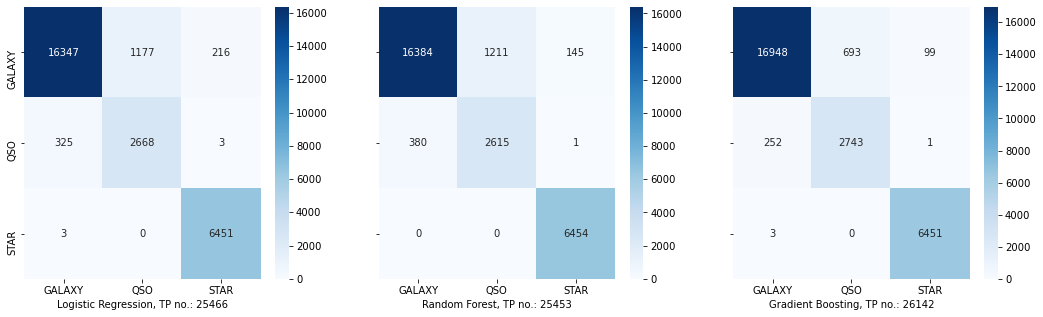

In [66]:
fig, ax = plt.subplots(1,3, figsize=(18,5),sharey=True)
model_names = ['Logistic Regression','Random Forest','Gradient Boosting']
labels = ['GALAXY','QSO','STAR']

for idx, grid in enumerate([lgr_smo, rf_smo, gbc_smo]):
    y_pred = grid.best_estimator_.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', ax=ax[idx], xticklabels=labels, yticklabels=labels, cmap='Blues')
    ax[idx].set_xlabel('{}, TP no.: {}'.format(model_names[idx], np.diag(cm).sum()))

<p> A closer look at the <strong>Confusion Matrices</strong> suggests the Random Forest model always predicts STAR correctly at a trade-off of overall scores, while Gradient Boosting gives the best over predicting results.</p>

<h2> Summary </h2>

<p> From the above analysis, the <strong>best model</strong> in prediction is <strong>Gradient Boosting with SMOTE resampling</strong>, for this <strong>multi-class classification</strong> it achieves overall: </p>
<ul>
    <strong>
    <li>Accuracy 0.961 </li><li>Precision 0.923 </li><li>Recall 0.957 </li><li>F1 score 0.938 </li>
    </strong>
    </ul>

<p> As supported by the analysis on the coefficients the Logistic Regression model, <strong>Redshift</strong> is the dominating factor for predicting the class. It is about 2 orders higher than the other measuresments.</p>
<p> Coefficients of Redshift for Galaxy and QSO are close. It suggests <strong>GALAXY and QSO </strong> may be <strong>easily mixed up</strong>.</p>
<p> The coefficient of Redshift of <strong>STAR</strong> has the opposite sign with that of GALAXY and QSO, suggesting it can be <strong>easily distinguished</strong> from the rest, and it is evidenced by the prediction results.</p>
<p>In particular, the Random Forest model, though with the lowest scores among the models, could always predict STAR correctly using the testing data.</p>

<h3> Possible Improvements </h3>
<p> The authenticity of original dataset may be improved by <strong>clarification of further suspected (and dropped) outliers</strong>.</p>
<p>A <strong>finer scale of hyperparameters</strong> may be deployed to refine the models. </p>